Import reviews from trustpilot (focus on both product and company itself (aacc)

Steps (not having a rating):
 - get polarity from analyzing reviews (textblob)
 - get clusters from analyzing reviews by topic modelling
 - also have other variables: review_len, time
 
 
Model that predicts rating based on this things (train/test). For other uses (mail, twitter... take out review_len as it will be different)

## Hellofresh

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
import plotly.express as px
import seaborn as sns
from pprint import pprint
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer as TV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import datetime


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim  
import pyLDAvis.sklearn

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


## 1. Dataset cleaning and exploration

In [2]:
data = pd.read_csv('./data/hellofresh.csv', index_col=0)
data.columns = ['review_id', 'date', 'rating', 'review_title', 'review_text',
       'review_response', 'response_dummy']

### 1.1. Droping unwanted columns

In [3]:
# droping columns
data.drop(['review_id', 'review_response', 'response_dummy', 'review_title'], axis=1, inplace=True)

### 1.2. Changing datatypes

In [4]:
# changing 'date' fo datatime data type
data.date = data.date.astype('datetime64[ns]')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31740 entries, 0 to 31739
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         31740 non-null  datetime64[ns]
 1   rating       31740 non-null  int64         
 2   review_text  30180 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 991.9+ KB


### 1.3. Droping NaNs

In [6]:
# NaNs as percentage - keep NaNs for title, remove the rest as the % is very low
data.isnull().sum()/len(data)*100

date           0.000000
rating         0.000000
review_text    4.914934
dtype: float64

In [7]:
data.dropna(inplace=True)
data.reset_index()

,index,date,rating,review_text
0,0,2020-08-18,3,I wish I could give my experience with Hello F...
1,1,2020-08-17,4,"Great recipes, easy-to-follow instructions, an..."
2,2,2020-08-17,3,A key ingredient was unusable for one of the m...
3,3,2020-08-17,5,Hello Fresh has great food and the best custom...
4,4,2020-08-16,5,"Delicious and easy recipes, high-quality ingre..."
...,...,...,...,...
30175,31735,2015-06-19,4,I am so pleased with my subscription to Hellof...
30176,31736,2015-06-19,4,"i've been mostly happy with the food, but have..."
30177,31737,2015-06-19,5,its perfect for me because I like to cook at h...
30178,31738,2015-06-19,5,I have been using HelloFresh for a couple mont...


We should take out the entries with no *review_text* as we are using this variable.

In [8]:
data.rating.mean()

4.456660039761432

### 1.4. Adding *polarity* and *subjectivity* for customer reviews

In [9]:
data['polarity'] = data['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['review_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [10]:
data.head()

,date,rating,review_text,polarity,subjectivity
0,2020-08-18,3,I wish I could give my experience with Hello F...,0.150000,0.594444
1,2020-08-17,4,"Great recipes, easy-to-follow instructions, an...",0.366667,0.750000
2,2020-08-17,3,A key ingredient was unusable for one of the m...,0.218056,0.701389
3,2020-08-17,5,Hello Fresh has great food and the best custom...,0.700000,0.516667
4,2020-08-16,5,"Delicious and easy recipes, high-quality ingre...",0.711111,0.811111


### 1.5. Adding column for review length, in words

In [11]:
data['review_words'] = data.review_text.apply(lambda x: len(str(x).split()))

### 1.6. Adding column *sentiment*


In [12]:
def sentiment(x):
    if x>=0.5:
        return 4
    elif 0<=x<0.5:
        return 3
    elif -0.5<=x<0:
        return 2
    else:
        return 1

In [13]:
# 4 best, 1 worse
data['sentiment'] = data.polarity.apply(sentiment)

### 1.5. Exporting clean dataset

In [14]:
data_original = data.copy()

## 2. Data Exploration 

### 2.1. Rating over time

__*Rating by month*__

In [ ]:
data_time = pd.read_csv('./data/hellofresh.csv', parse_dates=['date'], index_col='date')

In [ ]:
data_time = data_time.resample('M').mean()

In [ ]:
data_time.reset_index(inplace=True)

In [ ]:
data_time

In [ ]:
px.line(data_time, x=data_time['date'], y=data_time['stars'])

__*Rating by year*__

In [ ]:
data_time = pd.read_csv('./data/hellofresh.csv', parse_dates=['date'], index_col='date')

In [ ]:
data_time = data_time.resample('Y').mean()

In [ ]:
data_time.reset_index(inplace=True)

In [ ]:
data_time

In [ ]:
px.line(data_time, x=data_time['date'], y=data_time['stars'])

### 2.3. Exploring numerical columns

In [ ]:
data.hist(figsize=(20,15))
plt.show()

### 2.3. Exploring ngrams

In [ ]:
# corpus: list of strings to process
# n: number of ngrams you want to retrieve, ordered by frequencie (e.g. top 20)
# ngram: ngram (1=1 word, 2=2 consecutive words...)

def top_n_ngram(corpus, n, ngram):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]


__Unigram__

In [ ]:
common_words = top_n_ngram(data.review_text, 20,1)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
px.histogram(df, df['ReviewText'], df['count'])

__Bigram__

In [ ]:
common_words = top_n_ngram(data.review_text, 20,2)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
px.histogram(df, df['ReviewText'], df['count'])

__Trigrams__

In [ ]:
common_words = top_n_ngram(data.review_text, 20,3)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
px.histogram(df, df['ReviewText'], df['count'])

__POS tagging__

In corpus linguistics, part-of-speech tagging (POS tagging or PoS tagging or POST), also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech,[1] based on both its definition and its context. A simplified form of this is commonly taught to school-age children, in the identification of words as nouns, verbs, adjectives, adverbs, etc.

In [ ]:
blob= TextBlob(str(data['review_text']))
pos = pd.DataFrame(blob.tags,columns =['word','pos'])
pos1 = pos.pos.value_counts()[:20]
pos1 = pd.DataFrame(pos1).reset_index()
pos1.columns = ['pos', 'count']
px.histogram(pos1, x=pos1['pos'], y=pos1['count'])

### 2.4. Correlation

In [ ]:
sns.heatmap(data.corr(),annot = True)

### 2.5. Statistical description of data

In [ ]:
data.groupby(data['rating']).describe().T 
# both mean polarity and mean sentiment increase with higher ratings, so it seems to be a good measure

## 3. Topic Modelling

We created dictionary and corpus required for Topic Modeling: The two main inputs to the LDA topic model are the dictionary and the corpus. Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 1) below in the output implies, word id 0 occurs once in the first document.

In [17]:
# Import required packages
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Convert reviews to array
docs = np.array(data.review_text)
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.5)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 4154
Number of documents: 30180
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 6), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 3), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 4), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 1), (49, 2), (50, 2), (51, 3), (52, 1), (53, 1), (54, 3), (55, 3)]]


We have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well.Set number of topics=5.

In [18]:
# Set parameters.
num_topics = 5
chunksize = 10000 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

KeyboardInterrupt: 

LDA is an unsupervised technique, meaning that we don’t know prior to running the model how many topics exits in our corpus.You can use LDA visualization tool pyLDAvis, tried a few numbers of topics and compared the results. Topic coherence is one of the main techniques used to estimate the number of topics.We will use the c_v measure to see the coherence score of our LDA model.

In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

The last step is to find the optimal number of topics.We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', 
                       chunksize=10000, iterations=400, passes=20, eval_every=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values




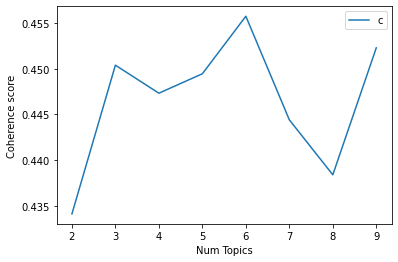

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=10, step=1)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [25]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075561  0.033375       1        1  39.755543
2     -0.004654 -0.061259       2        1  35.233105
0      0.080214  0.027885       3        1  25.011358, topic_info=                 Term          Freq         Total Category  logprob  loglift
19        hello_fresh  27902.000000  27902.000000  Default  30.0000  30.0000
79   customer_service   7493.000000   7493.000000  Default  29.0000  29.0000
18              hello   9392.000000   9392.000000  Default  28.0000  28.0000
67       easy_prepare   3905.000000   3905.000000  Default  27.0000  27.0000
78           customer   3497.000000   3497.000000  Default  26.0000  26.0000
..                ...           ...           ...      ...      ...      ...
120        hellofresh   1416.967896   5326.581055   Topic3  -5.1540   0.0616
339             would   1407.801025   5475.955078   Topic3  -5.1605   0.0275
40             recipe   1883.986816  12068.789062   Topic3  -4.8692  -0.4714
57               easy   1575.904785   9780.982422   Topic3  -5.0477  -0.4398
16               good   1323.514160   6258.714355   Topic3  -5.2223  -0.1678

[285 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
172       1  0.538439           about
172       2  0.246826           about
172       3  0.214787           about
2819      1  0.958599   absolute_best
2819      2  0.020839   absolute_best
...     ...       ...             ...
2429      2  0.011460   year_daughter
2429      3  0.022920   year_daughter
2427      1  0.937800  your_fingertip
2427      2  0.020840  your_fingertip
2427      3  0.020840  your_fingertip

[648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [26]:
lda_model1 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [27]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model1, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.167485 -0.018612       1        1  20.290680
5     -0.010866  0.034895       2        1  18.957415
1      0.064784 -0.057969       3        1  18.173319
2      0.021646  0.080613       4        1  16.453493
4      0.031664 -0.056593       5        1  16.232868
0      0.060256  0.017666       6        1   9.892219, topic_info=                 Term          Freq         Total Category  logprob  loglift
19        hello_fresh  24917.000000  24917.000000  Default  30.0000  30.0000
18              hello   8394.000000   8394.000000  Default  29.0000  29.0000
58        easy_follow   7570.000000   7570.000000  Default  28.0000  28.0000
79   customer_service   8125.000000   8125.000000  Default  27.0000  27.0000
67       easy_prepare   3791.000000   3791.000000  Default  26.0000  26.0000
..                ...           ...           ...      ...      ...      ...
55               with    758.575500  11207.793945   Topic6  -4.8514  -0.3795
408              make    631.512329   5421.350586   Topic6  -5.0347   0.1634
120        hellofresh    594.842529   5449.841797   Topic6  -5.0945   0.0984
113              cook    514.741272   4118.591309   Topic6  -5.2392   0.2338
47               time    522.573669   7294.509766   Topic6  -5.2241  -0.3227

[462 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
172       1  0.194630  about
172       2  0.260824  about
172       3  0.223281  about
172       4  0.073110  about
172       5  0.190349  about
...     ...       ...    ...
2209      2  0.031015   zone
2209      3  0.062030   zone
2209      4  0.031015   zone
2209      5  0.847744   zone
2209      6  0.020677   zone

[1938 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 3, 5, 1])

In [29]:
def format_topics_sentences(ldamodel=lda_model1, corpus=corpus, texts=data.review_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model1, corpus=corpus, texts=data.review_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4466,"customer_service, service, they, customer, thi...",I wish I could give my experience with Hello F...
1,1,2.0,0.9983,"easy_follow, easy_prepare, delicious, follow, ...","Great recipes, easy-to-follow instructions, an..."
2,2,2.0,0.9988,"easy_follow, easy_prepare, delicious, follow, ...",A key ingredient was unusable for one of the m...
3,3,1.0,0.9972,"customer_service, service, they, customer, thi...",Hello Fresh has great food and the best custom...
4,4,0.0,0.9989,"like, good, time, very, would, week, ingredien...","Delicious and easy recipes, high-quality ingre..."
5,5,2.0,0.6257,"easy_follow, easy_prepare, delicious, follow, ...",HelloFresh is the complete package. All the i...
6,6,1.0,0.6427,"customer_service, service, they, customer, thi...",I absolutely love HelloFresh! I've enjoyed ea...
7,7,1.0,0.8205,"customer_service, service, they, customer, thi...",At first I loved this service. Cooking for one...
8,8,2.0,0.9995,"easy_follow, easy_prepare, delicious, follow, ...",We think HelloFresh is fantastic. The recipes ...
9,9,0.0,0.9995,"like, good, time, very, would, week, ingredien...","Given our busy work schedules at the hospital,..."


In [30]:
data_change_name = data.copy()
data_change_name.columns = ['date', 'rating', 'Text', 'polarity', 'subjectivity',
       'review_words', 'sentiment']

In [31]:
data_final = pd.merge(data_change_name, df_dominant_topic, on='Text', how='left')

In [32]:
data_final.dropna()

,date,rating,Text,polarity,subjectivity,review_words,sentiment,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,2020-08-18,3,I wish I could give my experience with Hello F...,0.150000,0.594444,121,3,0,1.0,0.4466,"customer_service, service, they, customer, thi..."
1,2020-08-17,4,"Great recipes, easy-to-follow instructions, an...",0.366667,0.750000,15,3,1,2.0,0.9983,"easy_follow, easy_prepare, delicious, follow, ..."
2,2020-08-17,3,A key ingredient was unusable for one of the m...,0.218056,0.701389,35,3,2,2.0,0.9988,"easy_follow, easy_prepare, delicious, follow, ..."
3,2020-08-17,5,Hello Fresh has great food and the best custom...,0.700000,0.516667,11,4,3,1.0,0.9972,"customer_service, service, they, customer, thi..."
4,2020-08-16,5,"Delicious and easy recipes, high-quality ingre...",0.711111,0.811111,15,4,4,0.0,0.9989,"like, good, time, very, would, week, ingredien..."
...,...,...,...,...,...,...,...,...,...,...,...
28637,2016-04-08,5,My husband and I are amazed with the consisten...,0.462000,0.568000,31,3,30175,0.0,0.6936,"like, good, time, very, would, week, ingredien..."
28638,2016-04-08,5,I have been referred to as obsessive about foo...,0.158750,0.333214,121,3,30176,0.0,0.9992,"like, good, time, very, would, week, ingredien..."
28639,2016-04-08,4,I enjoy all the recipes but ever once in a whi...,-0.016667,0.266667,32,2,30177,2.0,0.9988,"easy_follow, easy_prepare, delicious, follow, ..."
28640,2016-04-08,3,"To be honest, I have only received two deliver...",0.238854,0.584896,162,3,30178,1.0,0.3580,"customer_service, service, they, customer, thi..."


In [33]:
data_final.to_csv('./data/hellofresh_by_topic.csv') # exporting dataset

In [34]:
data_final.groupby('Dominant_Topic').describe()

rating                                              polarity  \
                  count      mean       std  min  25%  50%  75%  max    count   
Dominant_Topic                                                                  
0.0             10965.0  4.455084  0.919960  1.0  4.0  5.0  5.0  5.0  10965.0   
1.0              6711.0  4.434660  0.936358  1.0  4.0  5.0  5.0  5.0   6711.0   
2.0             10966.0  4.467627  0.893611  1.0  4.0  5.0  5.0  5.0  10966.0   

                          ... Document_No          Topic_Perc_Contrib  \
                    mean  ...         75%      max              count   
Dominant_Topic            ...                                           
0.0             0.360513  ...     23048.0  30176.0            10965.0   
1.0             0.355280  ...     22405.5  30178.0             6711.0   
2.0             0.359586  ...     23143.5  30179.0            10966.0   

                                                                            
                    mean       std     min     25%     50%     75%     max  
Dominant_Topic                                                              
0.0             0.893766  0.171465  0.3333  0.7891  0.9975  0.9989  0.9999  
1.0             0.885205  0.173325  0.3425  0.7492  0.9978  0.9992  1.0000  
2.0             0.911645  0.159824  0.3489  0.9530  0.9975  0.9988  0.9998  

[3 rows x 56 columns]

In [35]:
data_final.loc[data_final.Dominant_Topic==0]['Text'].values[300]

'Awesome!  Great choices, varied dishes. Puts to end the what’s for dinner tonight question. Love it!'

## 4. Merging datasets

In [ ]:
data_merged = pd.merge(data, df_dominant_topic, on='review_text', how='left')

In [ ]:
data_merged.isna().sum()

In [ ]:
# drop NaNs
data_merged.dropna(inplace=True)

### 4.1. Average rating by topic

Topic doesn't seem to influence the rating or polarity

In [ ]:
data_merged.groupby('Dominant_Topic').rating.mean() # does not change much

In [ ]:
data_merged.groupby('Dominant_Topic').polarity.mean()

In [ ]:
data_merged.groupby('Dominant_Topic').sentiment.mean()

## 5. Model building

In [ ]:
# X and Y split
X = data_merged.drop(['rating', 'date', 'Document_No', 'Keywords'], axis=1)
y = data_merged.rating

In [ ]:
# droping columns if they have high colinearity
corr_matrix = X.corr().abs() # doing correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(X[to_drop], axis=1, inplace=True) # drop 'review_words'
X

In [ ]:
y

## 5. Model building

### 5.1. RE + Tokenizing + Stemming + Corpus Creation

In [ ]:
corpus = []
X.index = np.arange(len(X))

In [ ]:
for i in range(len(X)):
    review = re.sub('[^a-zA-z]',' ',X['review_text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review =[ps.stem(i) for i in review if not i in set(stopwords.words('english'))]
    review =' '.join(review)
    corpus.append(review)

In [ ]:
corpus

In [ ]:
pd.DataFrame(corpus).to_csv('./data/corpus.csv') # saving it for later so that I don't have to run the code again

__5.2. Bag of Words Technique__

In [ ]:
cv  = CV(max_features = 3000,ngram_range=(1,1))
X_cv = cv.fit_transform(corpus).toarray()
y = y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size = 0.2, random_state = 0)

In [ ]:
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

__5.3. Term Frequency- Inverse Document Frequency Technique__

In [ ]:
tv = TV(ngram_range =(1,1),max_features = 3000)
X_tv = tv.fit_transform(corpus).toarray()

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

In [ ]:
len(corpus)

In [ ]:
len(y_train)

In [ ]:
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

In [ ]:
# testing
diff = y_pred - y_test
Counter(diff)

In [ ]:
Counter(y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier,X_test,y_test)

### 5.4. K-means classifier - results not good

In [ ]:
# X and Y split
X1 = data_merged.drop(['rating', 'date', 'Document_No', 'Keywords', 'review_text'], axis=1)
y1 = data_merged.rating

In [ ]:
# droping columns if they have high colinearity
corr_matrix = X1.corr().abs() # doing correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X1.drop(X[to_drop], axis=1, inplace=True) # drop 'review_words'
X1

In [ ]:
# test and train
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
neigh = KNeighborsClassifier()

neigh_search = GridSearchCV(estimator=neigh,
                             param_grid={"n_neighbors":[5,20,50,100,200,500],
                                          "weights":["uniform", "distance"]},
                             scoring="accuracy",
                             cv=5)

neigh_search.fit(X_train1, y_train1)

In [ ]:
cvres = neigh_search.cv_results_
sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True)

In [ ]:
neigh1 = KNeighborsClassifier(n_neighbors=200, weights='uniform').fit(X_train1, y_train1)
predictions = neigh1.predict(X_test1)

In [ ]:
confusion_matrix(y_test1,predictions)

## Testing it only with good or bad

## 5. Model building - good or bad reviews

In [ ]:
# changing rating for 1 if rating is 4 or 5, and 0 if rating is 1 or 2. Drop 3s
def new_rating(x):
    if x>=4:
        return 1
    if x<=2:
        return 0
    else:
        return np.nan

In [ ]:
data_merged2 = data_merged.copy()
data_merged2.rating = data_merged2.rating.apply(new_rating)

In [ ]:
data_merged2.isna().sum()

In [ ]:
data_merged2.dropna(inplace=True)

In [ ]:
data_merged2.rating.value_counts(normalize=True)

In [ ]:
# X and Y split
X2 = data_merged2.drop(['rating', 'date', 'Document_No', 'Keywords'], axis=1)
y2 = data_merged2.rating

In [ ]:
# droping columns if they have high colinearity
corr_matrix = X2.corr().abs() # doing correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X2.drop(X2[to_drop], axis=1, inplace=True) # drop 'review_words'
X2

In [ ]:
y2

### 5.1. RE + Tokenizing + Stemming + Corpus Creation

In [ ]:
corpus2 = []
X2.index = np.arange(len(X2))

In [ ]:
for i in range(len(X2)):
    review = re.sub('[^a-zA-z]',' ',X2['review_text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review =[ps.stem(i) for i in review if not i in set(stopwords.words('english'))]
    review =' '.join(review)
    corpus2.append(review)

In [ ]:
corpus2

In [ ]:
pd.DataFrame(corpus2).to_csv('./data/corpus2.csv') # saving it for later so that I don't have to run the code again

__5.2. Bag of Words Technique__

In [ ]:
cv2  = CV(max_features = 3000,ngram_range=(1,1))
X_cv2 = cv.fit_transform(corpus2).toarray()
y2 = y2.values

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cv2, y2, test_size = 0.2, random_state = 0)

In [ ]:
classifier2 = BernoulliNB()
classifier2.fit(X_train2, y_train2)

In [ ]:
y_pred2 = classifier2.predict(X_test2)
acc = accuracy_score(y_test2, y_pred2)
acc

__5.3. Term Frequency- Inverse Document Frequency Technique__

In [ ]:
tv2 = TV(ngram_range =(1,1),max_features = 3000)
X_tv2 = tv.fit_transform(corpus2).toarray()

In [ ]:
classifier2 = MultinomialNB()
classifier2.fit(X_train2, y_train2)

In [ ]:
y_pred2 = classifier2.predict(X_test2)
acc = accuracy_score(y_test2, y_pred2)
acc

In [ ]:
# testing
diff = y_pred2 - y_test2
Counter(diff)

In [ ]:
Counter(y_test2)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test2,y_pred2)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier2,X_test2,y_test2)

### 5.4. K-means classifier - results not good

In [ ]:
# changing rating for 1 if rating is 4 or 5, and 0 if rating is 1 or 2. Drop 3s
def new_rating(x):
    if x>=4:
        return 1
    if x<=2:
        return 0
    else:
        return np.nan

In [ ]:
data_merged3 = data_merged.copy()
data_merged3.rating = data_merged3.rating.apply(new_rating)

In [ ]:
data_merged3.dropna(inplace=True)

In [ ]:
# X and Y split
X1 = data_merged3.drop(['rating', 'date', 'Document_No', 'Keywords', 'review_text'], axis=1)
y1 = data_merged3.rating

In [ ]:
# test and train
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
neigh = KNeighborsClassifier()

neigh_search = GridSearchCV(estimator=neigh,
                             param_grid={"n_neighbors":[5,20,50,100,200,500],
                                          "weights":["uniform", "distance"]},
                             scoring="accuracy",
                             cv=5)

neigh_search.fit(X_train1, y_train1)

In [ ]:
cvres = neigh_search.cv_results_
sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True)

In [ ]:
neigh1 = KNeighborsClassifier(n_neighbors=200, weights='uniform').fit(X_train1, y_train1)
predictions = neigh1.predict(X_test1)

In [ ]:
confusion_matrix(y_test1,predictions)